**Q1**

In [4]:
import nltk
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("Downloading 'punkt'...")
    nltk.download('punkt', force=True)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("Downloading 'stopwords'...")
    nltk.download('stopwords', force=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 1000x500 with 0 Axes>

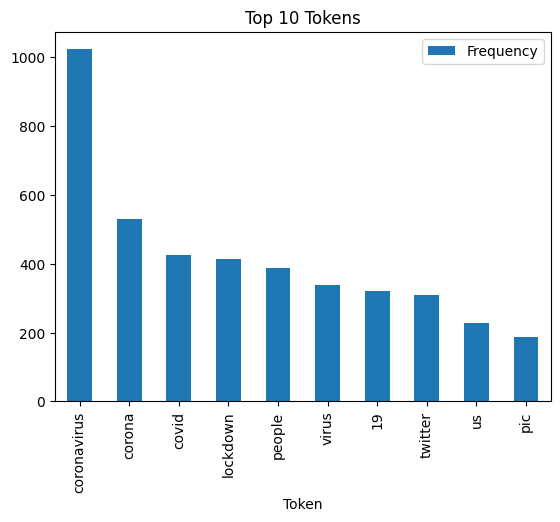

<Figure size 1000x500 with 0 Axes>

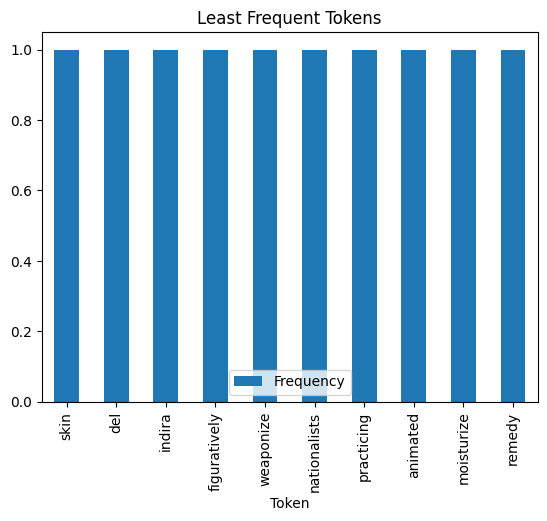

In [5]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

nltk.download('punkt_tab')
nltk.download('stopwords')

df = pd.read_csv('/content/finalSentimentdata2.csv')
if 'text' not in df.columns or 'sentiment' not in df.columns:
    raise KeyError("Dataset must contain 'text' and 'sentiment' columns.")
texts = df['text']
labels = df['sentiment']
stop_words = set(stopwords.words('english'))
processed_texts = []
for text in texts:
    tokens = word_tokenize(str(text).lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_texts.append(tokens)


def fit_transform_count_vectorizer(corpus):
    vocab = {}
    transformed = []
    for doc in corpus:
        doc_vector = Counter(doc)
        for word in doc:
            if word not in vocab:
                vocab[word] = len(vocab)
        transformed.append(doc_vector)
    vocab_size = len(vocab)
    data_matrix = np.zeros((len(corpus), vocab_size), dtype=int)
    for i, doc_vector in enumerate(transformed):
        for word, count in doc_vector.items():
            data_matrix[i][vocab[word]] = count
    return data_matrix, vocab

X, vocab = fit_transform_count_vectorizer(processed_texts)
token_counts = X.sum(axis=0)
token_names = list(vocab.keys())
token_freq = pd.DataFrame({'Token': token_names, 'Frequency': token_counts}).sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 5))
token_freq.head(10).plot(kind='bar', x='Token', y='Frequency', title='Top 10 Tokens')
plt.show()

plt.figure(figsize=(10, 5))
token_freq.tail(10).plot(kind='bar', x='Token', y='Frequency', title='Least Frequent Tokens')
plt.show()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


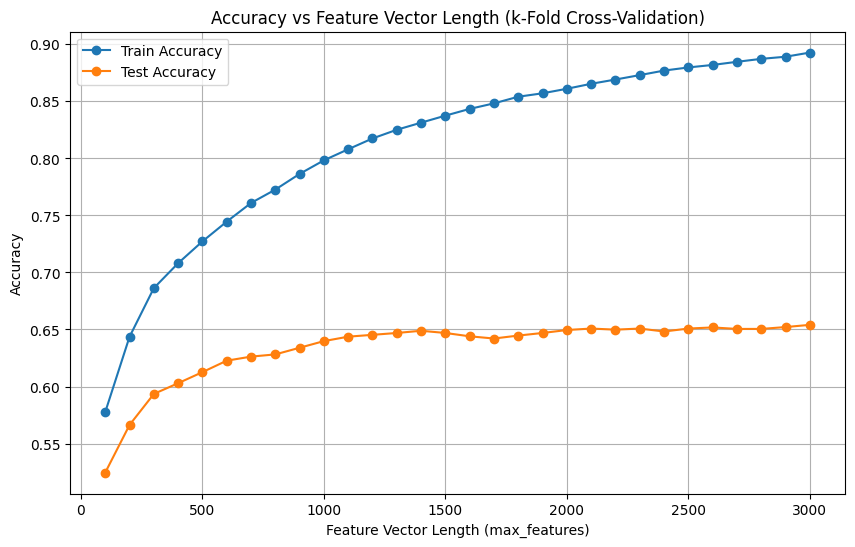

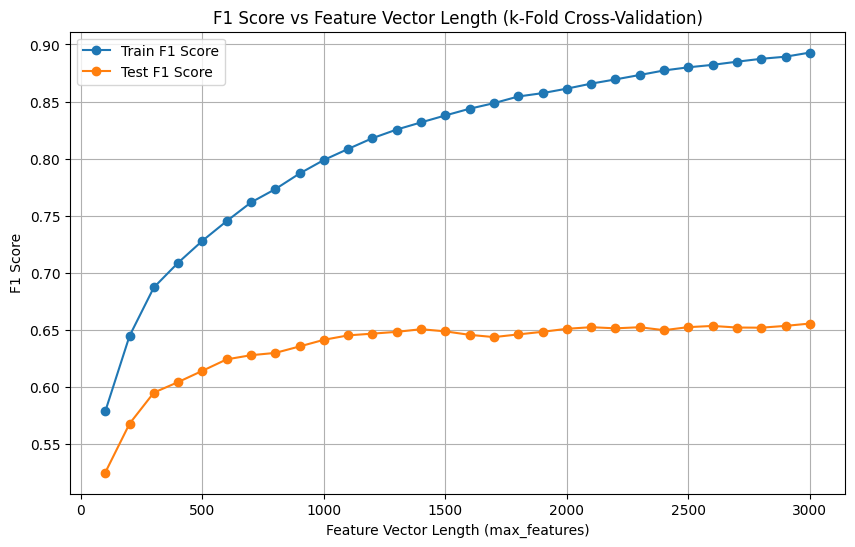

In [7]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

nltk.download('punkt')
nltk.download('stopwords')

df = pd.read_csv('/content/finalSentimentdata2.csv')
if 'text' not in df.columns or 'sentiment' not in df.columns:
    raise KeyError("Dataset must contain 'text' and 'sentiment' columns.")

texts = df['text']
labels = df['sentiment']

stop_words = set(stopwords.words('english'))
processed_texts = []
for text in texts:
    tokens = word_tokenize(str(text).lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    processed_texts.append(' '.join(tokens))

class CustomVectorizer:
    def __init__(self, max_features=None):
        self.max_features = max_features
        self.vocabulary = {}

    def fit(self, texts):
        word_counts = {}
        for text in texts:
            for word in text.split():
                word_counts[word] = word_counts.get(word, 0) + 1
        sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
        if self.max_features:
            sorted_words = sorted_words[:self.max_features]
        self.vocabulary = {word: idx for idx, (word, _) in enumerate(sorted_words)}

    def transform(self, texts):
        feature_matrix = np.zeros((len(texts), len(self.vocabulary)))
        for i, text in enumerate(texts):
            for word in text.split():
                if word in self.vocabulary:
                    feature_matrix[i, self.vocabulary[word]] += 1
        return feature_matrix

    def fit_transform(self, texts):
        self.fit(texts)
        return self.transform(texts)

class NaiveBayes:
    def __init__(self):
        self.class_probabilities = {}
        self.feature_probabilities = {}
        self.vocabulary_size = 0

    def fit(self, X, y):
        class_counts = {}
        feature_counts = {}

        for label in set(y):
            class_counts[label] = 0
            feature_counts[label] = {}

        total_documents = len(y)

        for features, label in zip(X, y):
            class_counts[label] += 1
            for idx, count in enumerate(features):
                if count > 0:
                    feature_counts[label][idx] = feature_counts[label].get(idx, 0) + count

        self.vocabulary_size = X.shape[1]

        self.class_probabilities = {label: count / total_documents for label, count in class_counts.items()}
        self.feature_probabilities = {}
        for label in class_counts:
            total_words_in_class = sum(feature_counts[label].values())
            self.feature_probabilities[label] = {}
            for idx in range(self.vocabulary_size):
                self.feature_probabilities[label][idx] = (
                    (feature_counts[label].get(idx, 0) + 1) / (total_words_in_class + self.vocabulary_size)
                )

    def predict(self, X):
        predictions = []
        for features in X:
            class_scores = {}
            for label in self.class_probabilities:
                score = np.log(self.class_probabilities[label])
                for idx, count in enumerate(features):
                    if count > 0:
                        prob = self.feature_probabilities[label].get(idx, 1 / self.vocabulary_size)
                        score += count * np.log(prob)
                class_scores[label] = score
            predictions.append(max(class_scores, key=class_scores.get))
        return predictions


kf = KFold(n_splits=5, shuffle=True, random_state=42)
feature_lengths = range(100, 3001, 100)

train_accuracies = []
test_accuracies = []
train_f1_scores = []
test_f1_scores = []

for max_features in feature_lengths:
    vectorizer = CustomVectorizer(max_features=max_features)
    fold_train_accuracies = []
    fold_test_accuracies = []
    fold_train_f1_scores = []
    fold_test_f1_scores = []

    for train_index, test_index in kf.split(processed_texts):
        X_train = [processed_texts[i] for i in train_index]
        X_test = [processed_texts[i] for i in test_index]
        y_train = labels.iloc[train_index].values
        y_test = labels.iloc[test_index].values

        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        model = NaiveBayes()
        model.fit(X_train_vec, y_train)

        y_train_pred = model.predict(X_train_vec)
        y_test_pred = model.predict(X_test_vec)

        fold_train_accuracies.append(accuracy_score(y_train, y_train_pred))
        fold_train_f1_scores.append(f1_score(y_train, y_train_pred, average='macro'))
        fold_test_accuracies.append(accuracy_score(y_test, y_test_pred))
        fold_test_f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))

    train_accuracies.append(np.mean(fold_train_accuracies))
    train_f1_scores.append(np.mean(fold_train_f1_scores))
    test_accuracies.append(np.mean(fold_test_accuracies))
    test_f1_scores.append(np.mean(fold_test_f1_scores))

plt.figure(figsize=(10, 6))
plt.plot(feature_lengths, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(feature_lengths, test_accuracies, label='Test Accuracy', marker='o')
plt.title('Accuracy vs Feature Vector Length (k-Fold Cross-Validation)')
plt.xlabel('Feature Vector Length (max_features)')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(feature_lengths, train_f1_scores, label='Train F1 Score', marker='o')
plt.plot(feature_lengths, test_f1_scores, label='Test F1 Score', marker='o')
plt.title('F1 Score vs Feature Vector Length (k-Fold Cross-Validation)')
plt.xlabel('Feature Vector Length (max_features)')
plt.ylabel('F1 Score')
plt.legend()
plt.grid()
plt.show()

**Q2**

Columns in the dataset: ['asia', 'tub', 'smoke', 'bronc', 'either', 'xray', 'dysp', 'lung']


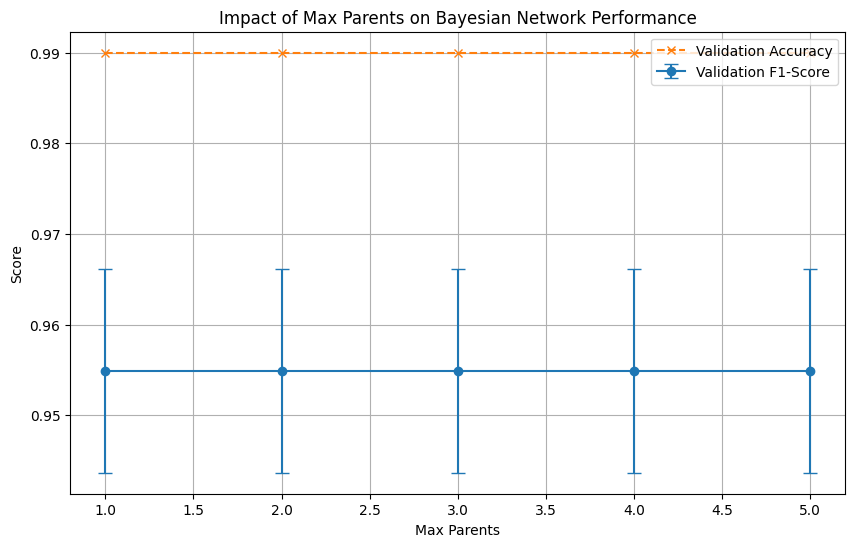

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

dataset_path = "/content/ASIA10k_v2.csv"
try:
    data = pd.read_csv(dataset_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file not found at: {dataset_path}")

print("Columns in the dataset:", list(data.columns))

target = 'lung'
if target not in data.columns:
    print(f"Warning: Target column '{target}' not found in the dataset.")
    print(f"Available columns: {list(data.columns)}")
    target = input("Please enter the correct target column name: ").strip()
    if target not in data.columns:
        raise ValueError(f"Provided target column '{target}' does not exist in the dataset.")

data_encoded = data.apply(lambda x: x.astype('category').cat.codes if x.dtype == 'object' else x)
data_encoded = data_encoded.fillna(data_encoded.median())
X = data_encoded.drop(columns=[target])
y = data_encoded[target]

try:
    train_data, test_data, train_labels, test_labels = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
except ValueError as e:
    raise ValueError(
        f"Error during train-test split. Ensure the target column '{target}' has no issues (e.g., only one class)."
    ) from e

class BayesianNetwork:
    def __init__(self):
        self.structure = {}
        self.parameters = {}
        self.target_node = None

    def fit(self, data, labels):
        """Fit the Bayesian Network with data."""
        data = pd.concat([data, labels], axis=1)
        self.target_node = labels.name
        for node, parents in self.structure.items():
            if not parents:
                self.parameters[node] = data[node].value_counts(normalize=True).to_dict()
            else:
                grouped = data.groupby(parents + [node]).size().reset_index(name='count')
                parent_grouped = data.groupby(parents).size().reset_index(name='parent_count')
                cpt = pd.merge(grouped, parent_grouped, on=parents, how='left')
                cpt['probability'] = cpt['count'] / cpt['parent_count']
                self.parameters[node] = cpt

    def predict(self, data):
        """Predict values using Bayesian inference."""
        predictions = pd.DataFrame(index=data.index)
        for node, parents in self.structure.items():
            if not parents:
                predictions[node] = data[node].map(lambda x: max(self.parameters[node], key=self.parameters[node].get))
            elif self.target_node not in predictions.columns:
                predictions[self.target_node] = data.apply(lambda row: self._predict_node(self.target_node, row), axis=1)
            else:
                predictions[node] = data.apply(lambda row: self._predict_node(node, row), axis=1)
        return predictions

    def _predict_node(self, node, row):
        """Predict a single node value."""
        parents = self.structure[node]
        if not parents:
            return max(self.parameters[node], key=self.parameters[node].get)
        parent_values = row[parents].to_dict()
        probabilities = self.parameters[node]
        filtered = probabilities.copy()
        for parent, value in parent_values.items():
            filtered = filtered[filtered[parent] == value]
        if filtered.empty:
            return np.nan
        return filtered[node].iloc[np.argmax(filtered['probability'])]

def k2_algorithm(data, node_order, max_parents):
    node_order = node_order + [data.columns[-1]]
    structure = {node: [] for node in node_order}
    for node in node_order:
        parents = []
        best_score = -np.inf
        while len(parents) < max_parents:
            potential_parents = [p for p in node_order if p != node and p not in parents]
            scores = {}
            for potential_parent in potential_parents:
                trial_parents = parents + [potential_parent]
                trial_score = calculate_bic(data, node, trial_parents)
                scores[potential_parent] = trial_score
            if not scores:
                break
            best_candidate, candidate_score = max(scores.items(), key=lambda x: x[1])
            if candidate_score > best_score:
                parents.append(best_candidate)
                best_score = candidate_score
            else:
                break
        structure[node] = parents
    return structure

def calculate_bic(data, node, parents):
    try:
        if not parents:
            prob = data[node].value_counts(normalize=True)
            likelihood = np.sum(np.log(data[node].map(prob)))
        else:
            grouped = data.groupby(parents + [node]).size().reset_index(name='count')
            parent_grouped = data.groupby(parents).size().reset_index(name='parent_count')
            cpt = pd.merge(grouped, parent_grouped, on=parents)
            cpt['probability'] = cpt['count'] / cpt['parent_count']
            likelihood = np.sum(np.log(cpt['probability']))
        n_params = (len(data[node].unique()) - 1) * (
            np.prod([len(data[parent].unique()) for parent in parents]) if parents else 1
        )
        bic_score = likelihood - (n_params * np.log(data.shape[0]) / 2)
        return bic_score
    except KeyError as e:
        print(f"KeyError for {node} with parents {parents}: {e}")
        return -np.inf

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
node_order = list(train_data.columns)
results = []
accuracy_scores = []

for max_parents in range(1, 6):
    fold_metrics = []
    fold_accuracies = []
    for train_index, val_index in kf.split(train_data, train_labels):
        fold_train_data, fold_val_data = train_data.iloc[train_index], train_data.iloc[val_index]
        fold_train_labels, fold_val_labels = train_labels.iloc[train_index], train_labels.iloc[val_index]

        structure = k2_algorithm(pd.concat([fold_train_data, fold_train_labels], axis=1), node_order, max_parents)
        model = BayesianNetwork()
        model.structure = structure
        model.fit(fold_train_data, fold_train_labels)

        val_pred = model.predict(fold_val_data)
        val_pred[target] = val_pred[target].fillna(val_pred[target].mode()[0])

        fold_metrics.append(f1_score(fold_val_labels, val_pred[target], average='macro'))
        fold_accuracies.append(accuracy_score(fold_val_labels, val_pred[target]))

    results.append({
        'max_parents': max_parents,
        'mean_f1': np.mean(fold_metrics),
        'std_f1': np.std(fold_metrics)
    })
    accuracy_scores.append(np.mean(fold_accuracies))

results_df = pd.DataFrame(results)
results_df.to_csv("bayesian_network_results.csv", index=False)

plt.figure(figsize=(10, 6))
plt.errorbar(
    results_df['max_parents'], results_df['mean_f1'], yerr=results_df['std_f1'],
    label='Validation F1-Score', marker='o', capsize=5
)
plt.plot(range(1, 6), accuracy_scores, label='Validation Accuracy', marker='x', linestyle='--')
plt.xlabel("Max Parents")
plt.ylabel("Score")
plt.title("Impact of Max Parents on Bayesian Network Performance")
plt.legend()
plt.grid()
plt.show()

Columns in the dataset: ['asia', 'tub', 'smoke', 'bronc', 'either', 'xray', 'dysp', 'lung']


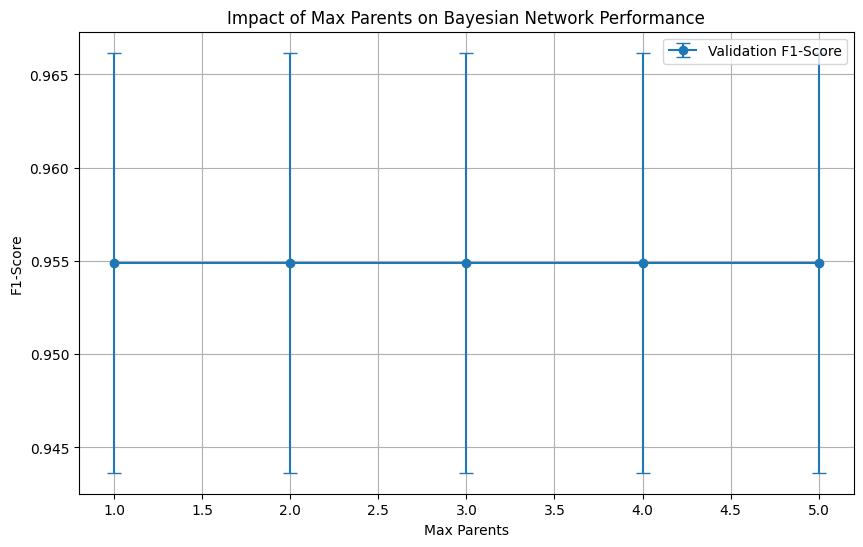

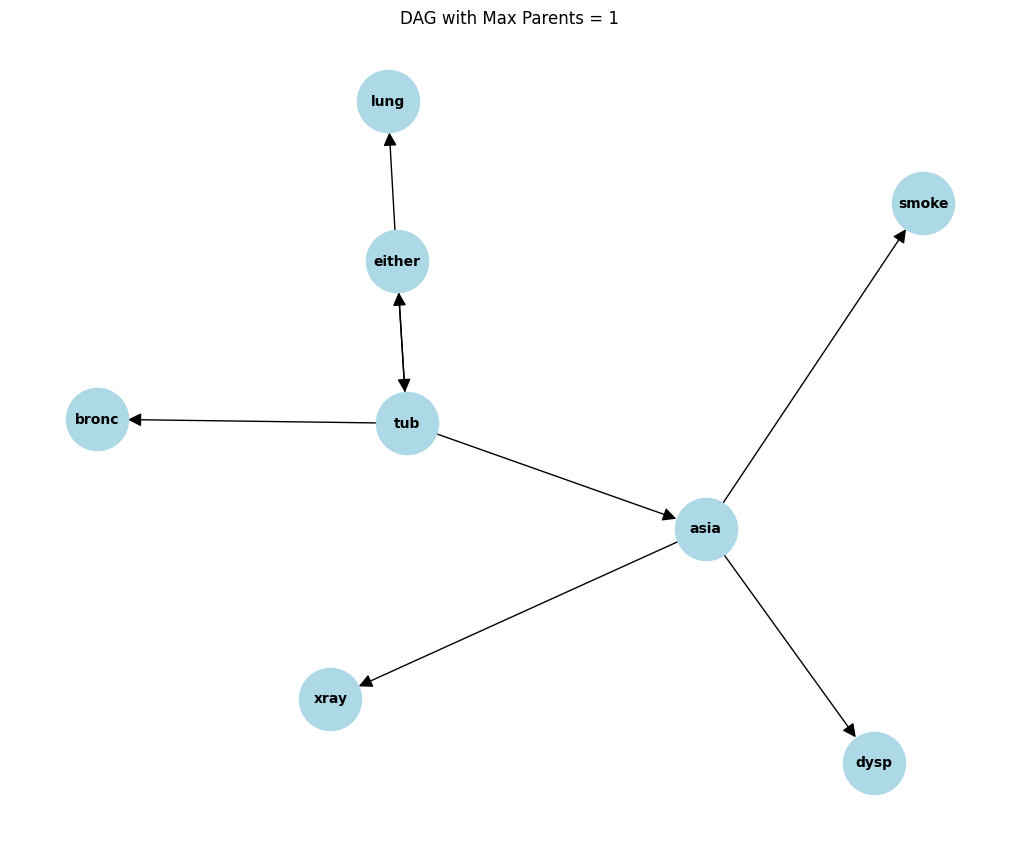

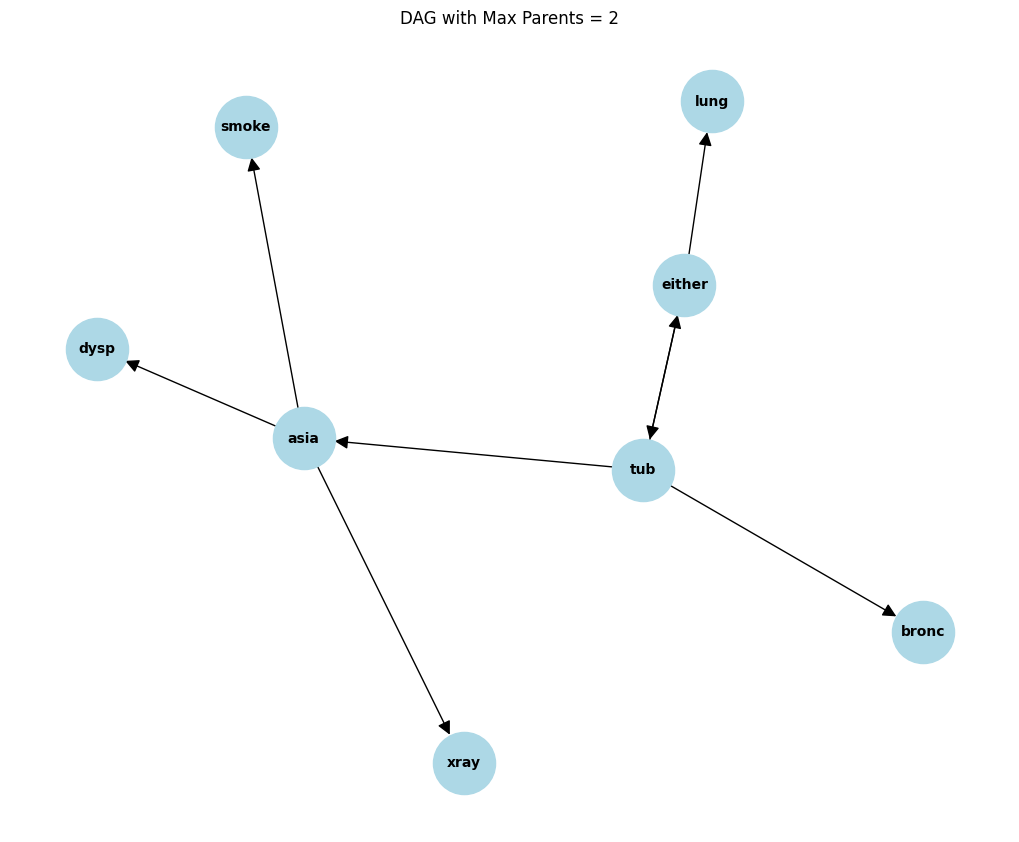

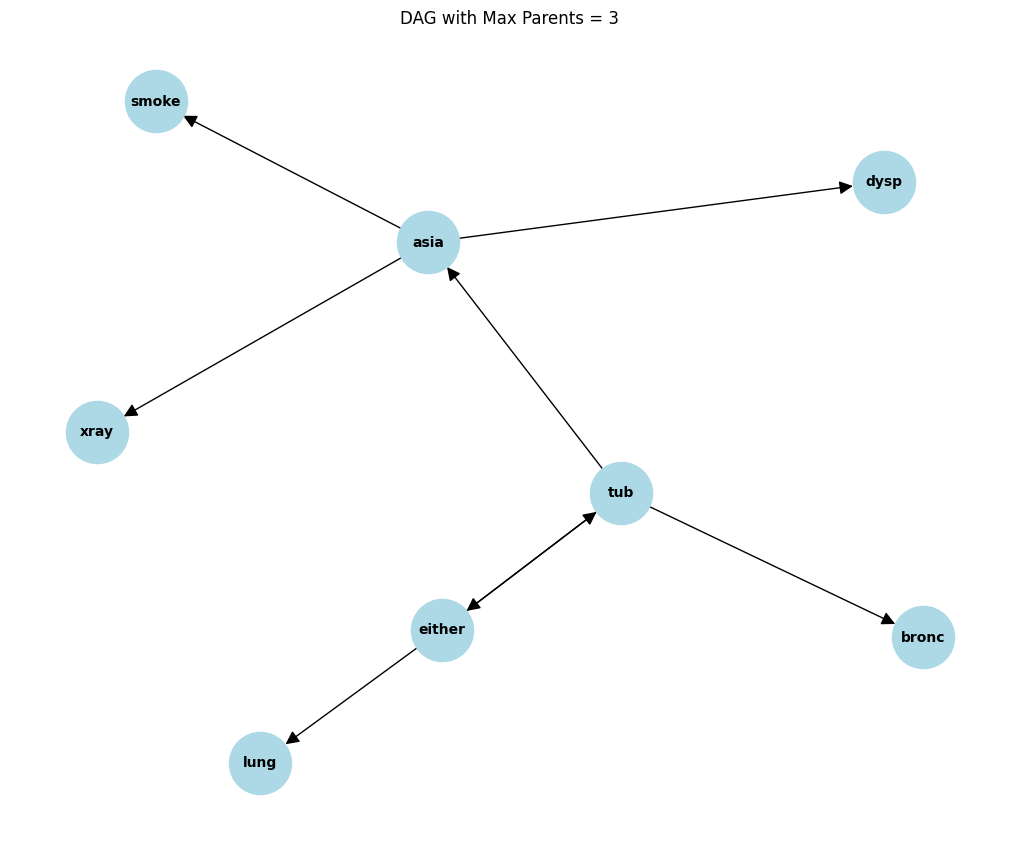

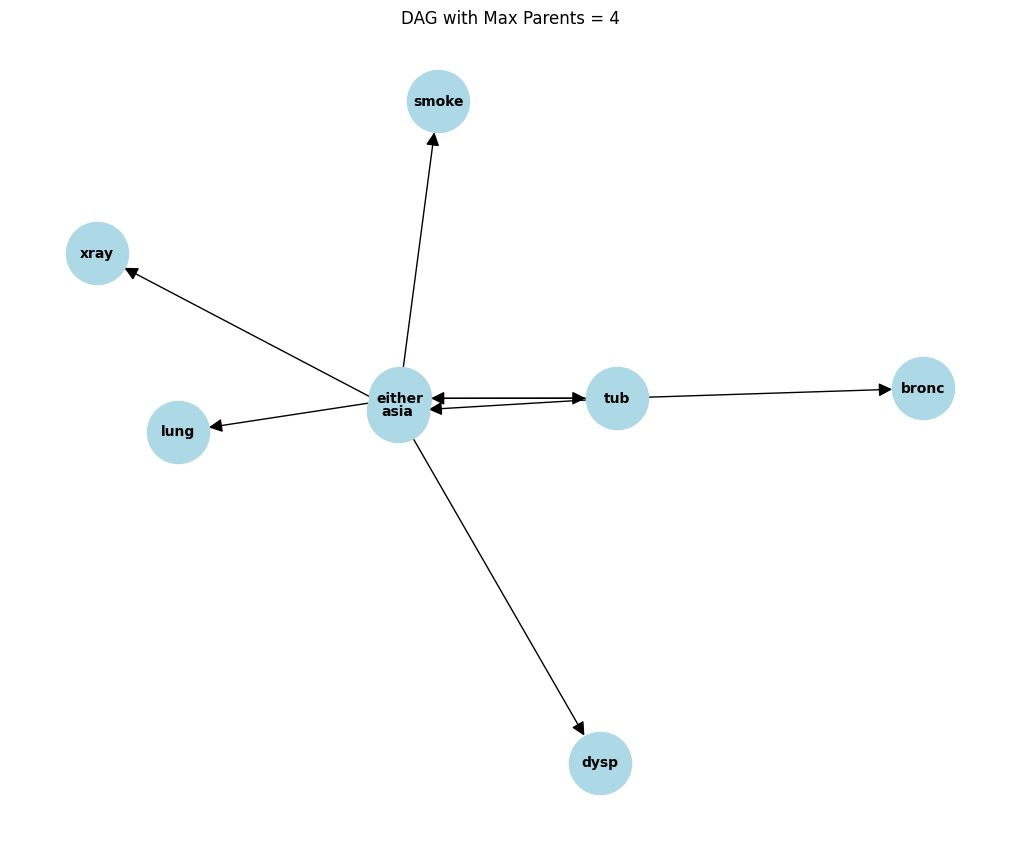

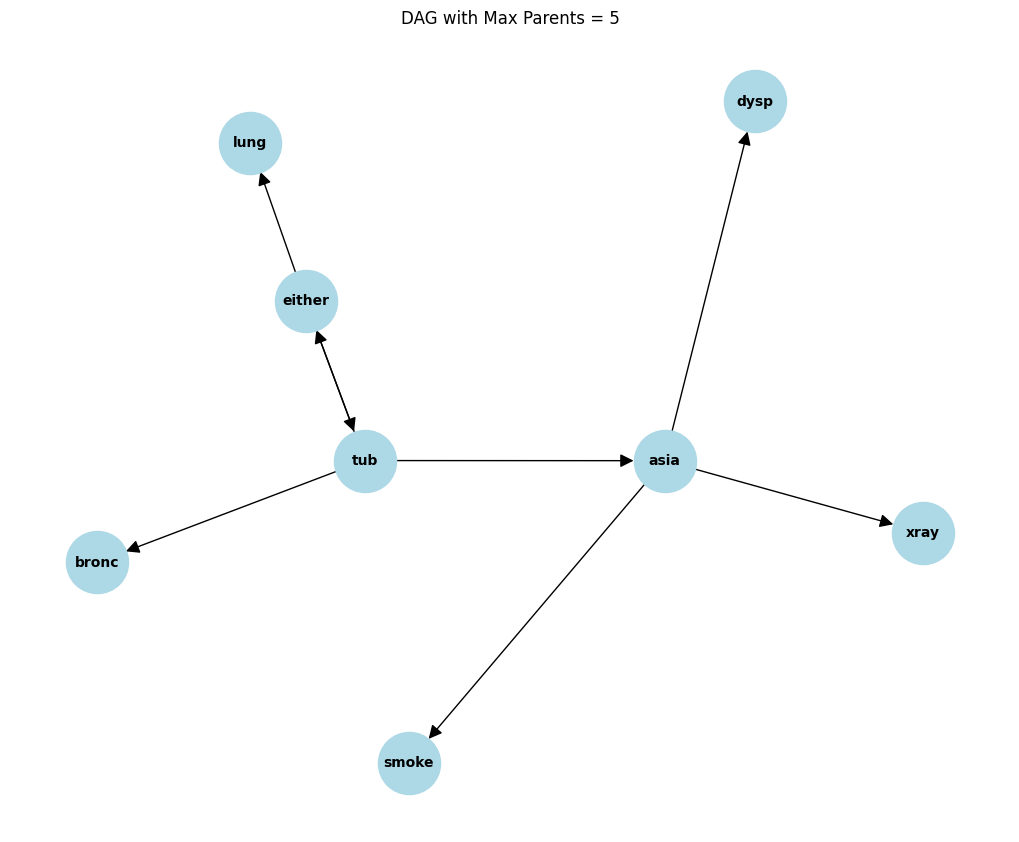

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

dataset_path = "/content/ASIA10k_v2.csv"
try:
    data = pd.read_csv(dataset_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file not found at: {dataset_path}")

print("Columns in the dataset:", list(data.columns))

target = 'lung'
if target not in data.columns:
    print(f"Warning: Target column '{target}' not found in the dataset.")
    print(f"Available columns: {list(data.columns)}")
    target = input("Please enter the correct target column name: ").strip()
    if target not in data.columns:
        raise ValueError(f"Provided target column '{target}' does not exist in the dataset.")

data_encoded = data.apply(lambda x: x.astype('category').cat.codes if x.dtype == 'object' else x)

data_encoded = data_encoded.fillna(data_encoded.median())

X = data_encoded.drop(columns=[target])
y = data_encoded[target]

try:
    train_data, test_data, train_labels, test_labels = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
except ValueError as e:
    raise ValueError(
        f"Error during train-test split. Ensure the target column '{target}' has no issues (e.g., only one class)."
    ) from e

class BayesianNetwork:
    def __init__(self):
        self.structure = {}
        self.parameters = {}
        self.target_node = None

    def fit(self, data, labels):
        """Fit the Bayesian Network with data."""
        data = pd.concat([data, labels], axis=1)
        self.target_node = labels.name
        for node, parents in self.structure.items():
            if not parents:
                self.parameters[node] = data[node].value_counts(normalize=True).to_dict()
            else:
                grouped = data.groupby(parents + [node]).size().reset_index(name='count')
                parent_grouped = data.groupby(parents).size().reset_index(name='parent_count')

                cpt = pd.merge(grouped, parent_grouped, on=parents, how='left')
                cpt['probability'] = cpt['count'] / cpt['parent_count']
                self.parameters[node] = cpt

    def predict(self, data):
        """Predict values using Bayesian inference."""
        predictions = pd.DataFrame(index=data.index)
        for node, parents in self.structure.items():
            if not parents:
                predictions[node] = data[node].map(lambda x: max(self.parameters[node], key=self.parameters[node].get))
            elif self.target_node not in predictions.columns:
                predictions[self.target_node] = data.apply(lambda row: self._predict_node(self.target_node, row), axis=1)
            else:
                predictions[node] = data.apply(lambda row: self._predict_node(node, row), axis=1)
        return predictions

    def _predict_node(self, node, row):
        """Predict a single node value."""
        parents = self.structure[node]
        if not parents:
            return max(self.parameters[node], key=self.parameters[node].get)
        parent_values = row[parents].to_dict()
        probabilities = self.parameters[node]
        filtered = probabilities.copy()
        for parent, value in parent_values.items():
            filtered = filtered[filtered[parent] == value]
        if filtered.empty:
            return np.nan
        return filtered[node].iloc[np.argmax(filtered['probability'])]

def k2_algorithm(data, node_order, max_parents):
    node_order = node_order + [data.columns[-1]]
    structure = {node: [] for node in node_order}
    for node in node_order:
        parents = []
        best_score = -np.inf
        while len(parents) < max_parents:
            potential_parents = [p for p in node_order if p != node and p not in parents]
            scores = {}
            for potential_parent in potential_parents:
                trial_parents = parents + [potential_parent]
                trial_score = calculate_bic(data, node, trial_parents)
                scores[potential_parent] = trial_score
            if not scores:
                break
            best_candidate, candidate_score = max(scores.items(), key=lambda x: x[1])
            if candidate_score > best_score:
                parents.append(best_candidate)
                best_score = candidate_score
            else:
                break
        structure[node] = parents
    return structure

def calculate_bic(data, node, parents):
    try:
        if not parents:
            prob = data[node].value_counts(normalize=True)
            likelihood = np.sum(np.log(data[node].map(prob)))
        else:
            grouped = data.groupby(parents + [node]).size().reset_index(name='count')
            parent_grouped = data.groupby(parents).size().reset_index(name='parent_count')
            cpt = pd.merge(grouped, parent_grouped, on=parents)
            cpt['probability'] = cpt['count'] / cpt['parent_count']
            likelihood = np.sum(np.log(cpt['probability']))
        n_params = (len(data[node].unique()) - 1) * (
            np.prod([len(data[parent].unique()) for parent in parents]) if parents else 1
        )
        bic_score = likelihood - (n_params * np.log(data.shape[0]) / 2)
        return bic_score
    except KeyError as e:
        print(f"KeyError for {node} with parents {parents}: {e}")
        return -np.inf

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
node_order = list(train_data.columns)
results = []

for max_parents in range(1, 6):
    fold_metrics = []
    for train_index, val_index in kf.split(train_data, train_labels):
        fold_train_data, fold_val_data = train_data.iloc[train_index], train_data.iloc[val_index]
        fold_train_labels, fold_val_labels = train_labels.iloc[train_index], train_labels.iloc[val_index]

        structure = k2_algorithm(pd.concat([fold_train_data, fold_train_labels], axis=1), node_order, max_parents)
        model = BayesianNetwork()
        model.structure = structure
        model.fit(fold_train_data, fold_train_labels)

        val_pred = model.predict(fold_val_data)
        val_pred[target] = val_pred[target].fillna(val_pred[target].mode()[0])

        fold_metrics.append(f1_score(fold_val_labels, val_pred[target], average='macro'))

    results.append({
        'max_parents': max_parents,
        'mean_f1': np.mean(fold_metrics),
        'std_f1': np.std(fold_metrics)
    })

results_df = pd.DataFrame(results)
results_df.to_csv("bayesian_network_results.csv", index=False)

plt.figure(figsize=(10, 6))
plt.errorbar(
    results_df['max_parents'], results_df['mean_f1'], yerr=results_df['std_f1'],
    label='Validation F1-Score', marker='o', capsize=5
)
plt.xlabel("Max Parents")
plt.ylabel("F1-Score")
plt.title("Impact of Max Parents on Bayesian Network Performance")
plt.legend()
plt.grid()
plt.show()
for max_parents in range(1, 6):
    structure = k2_algorithm(pd.concat([train_data, train_labels], axis=1), node_order, max_parents)
    G = nx.DiGraph()
    for node, parents in structure.items():
        for parent in parents:
            G.add_edge(parent, node)
    plt.figure(figsize=(10, 8))
    nx.draw(G, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
    plt.title(f"DAG with Max Parents = {max_parents}")
    plt.show

**Ready Library for Compare(Optional)**




In [13]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.4 MB/s eta 0:00:00


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Drawing DAG for max_parents=1


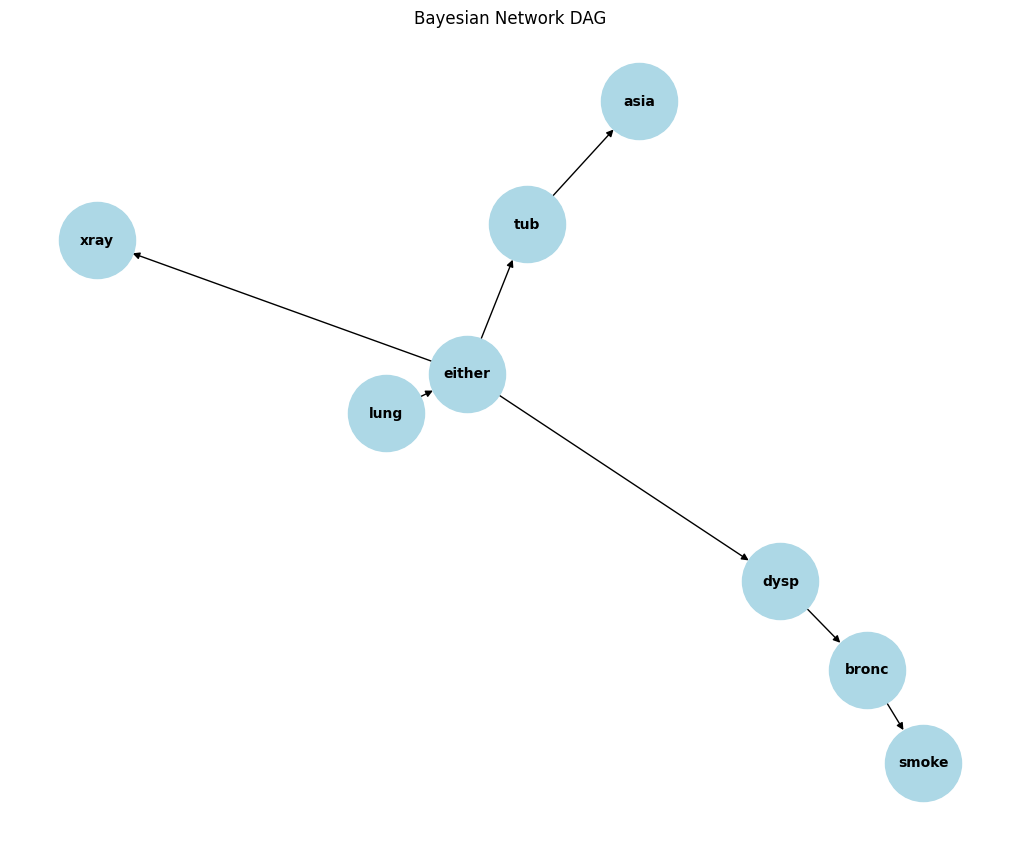

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Drawing DAG for max_parents=2


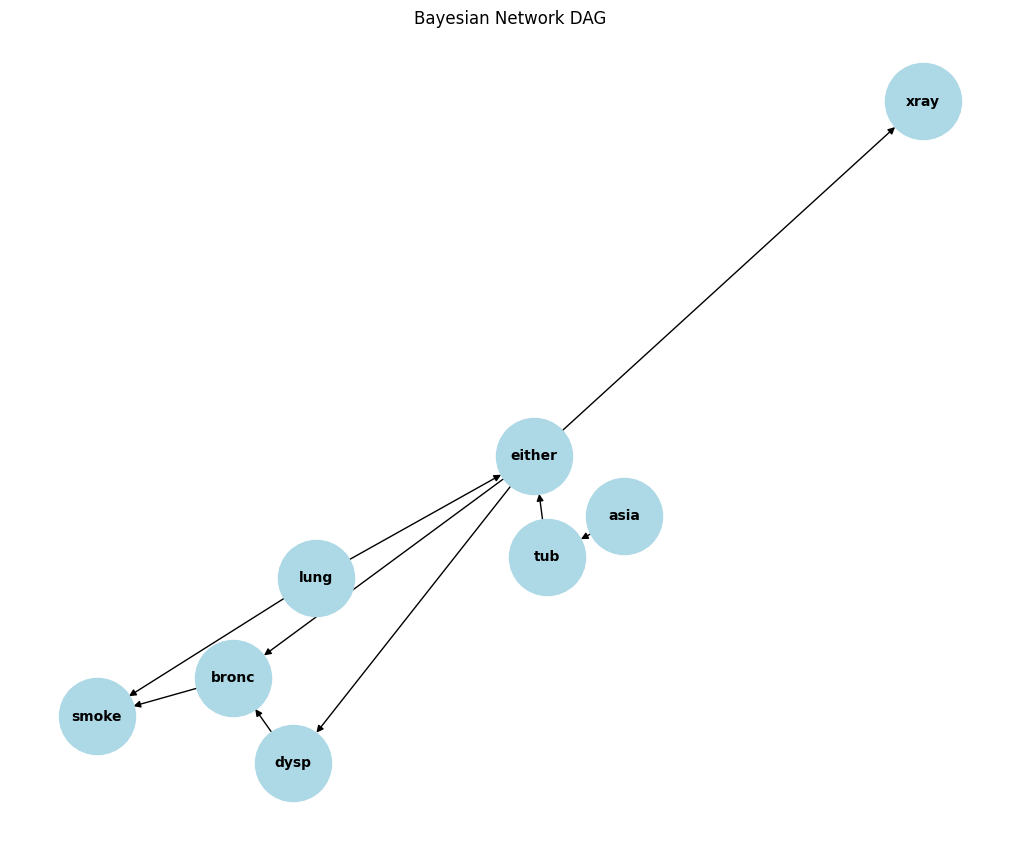

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Drawing DAG for max_parents=3


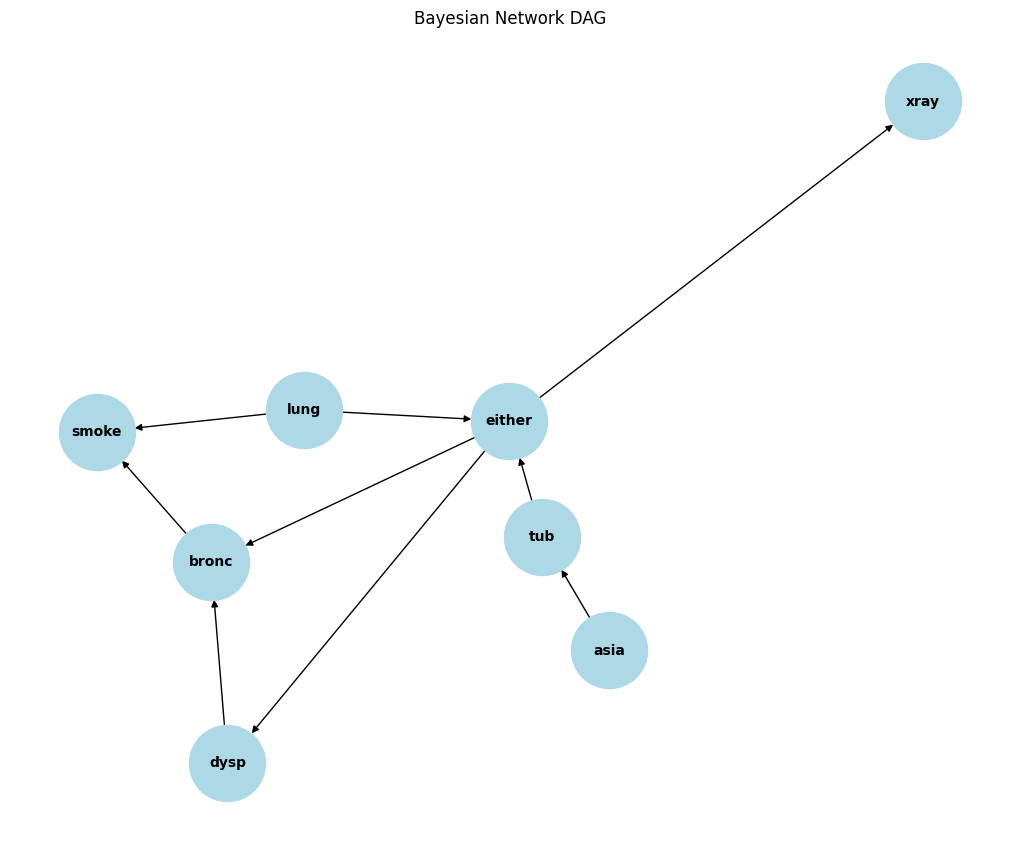

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Drawing DAG for max_parents=4


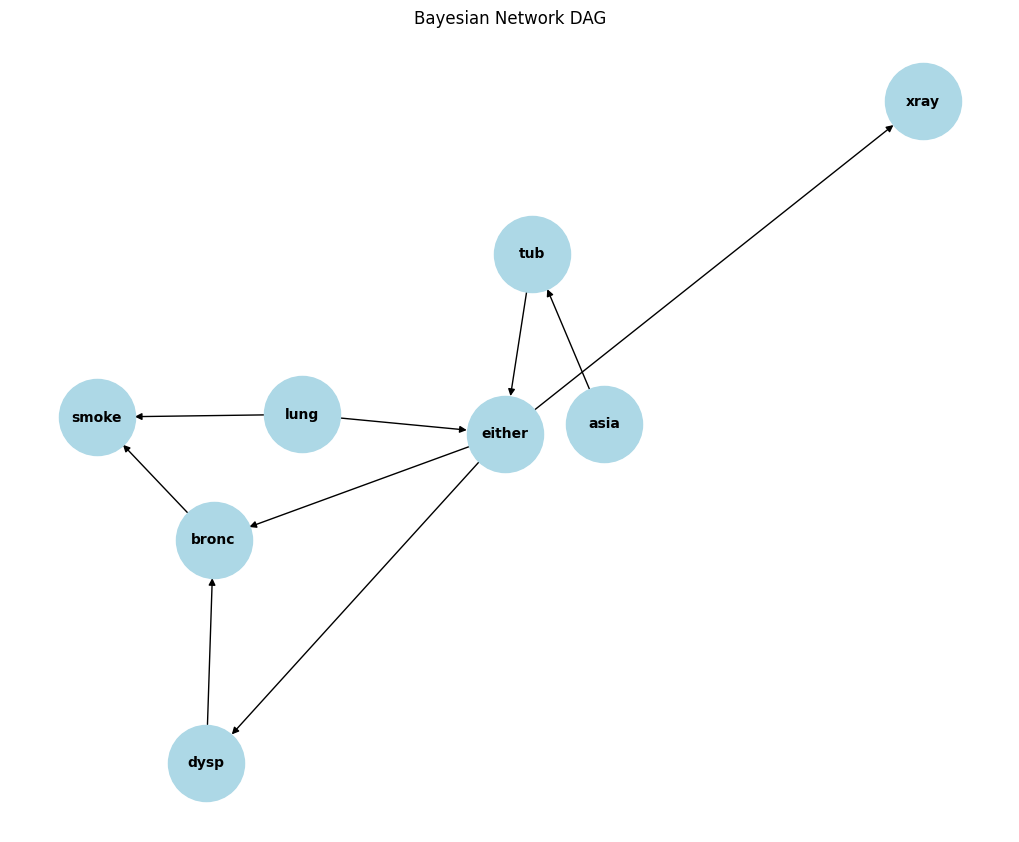

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

Drawing DAG for max_parents=5


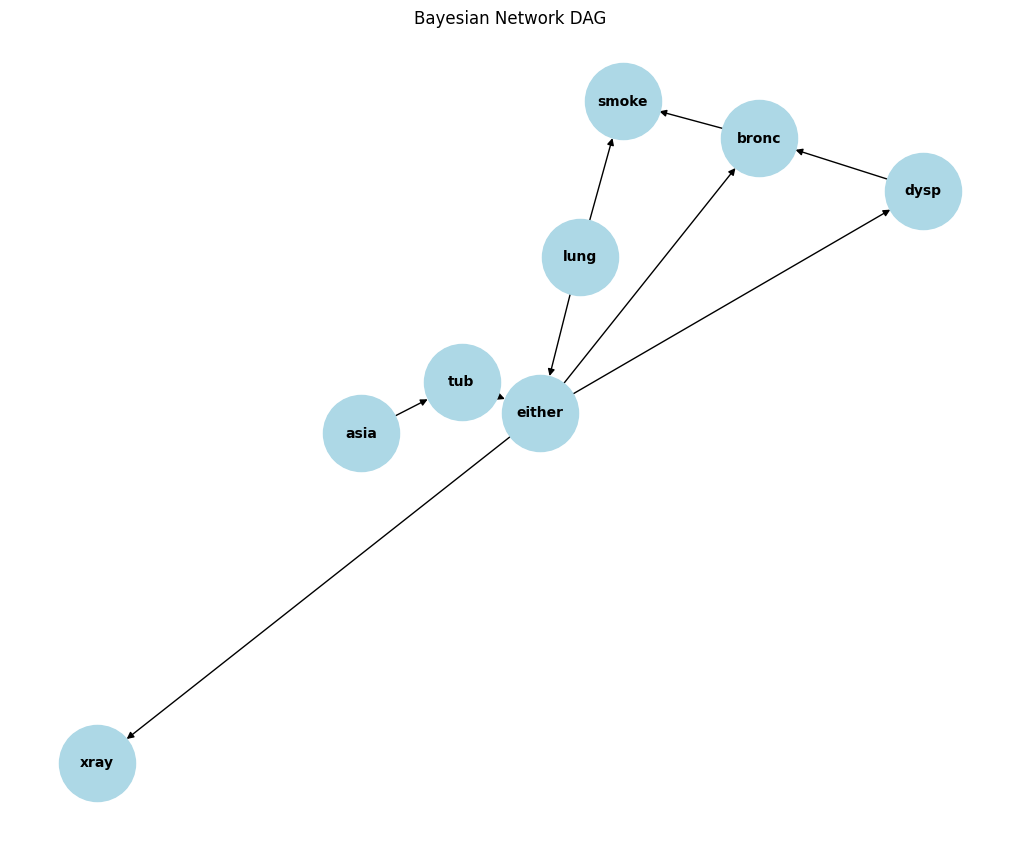

   train_accuracy  test_accuracy  train_f1   test_f1  max_parents
0        0.990286       0.990667  0.957036  0.954588            1
1        0.999286       0.999667  0.996560  0.998229            2
2        0.999286       0.999667  0.996560  0.998229            3
3        0.999286       0.999667  0.996560  0.998229            4
4        0.999286       0.999667  0.996560  0.998229            5


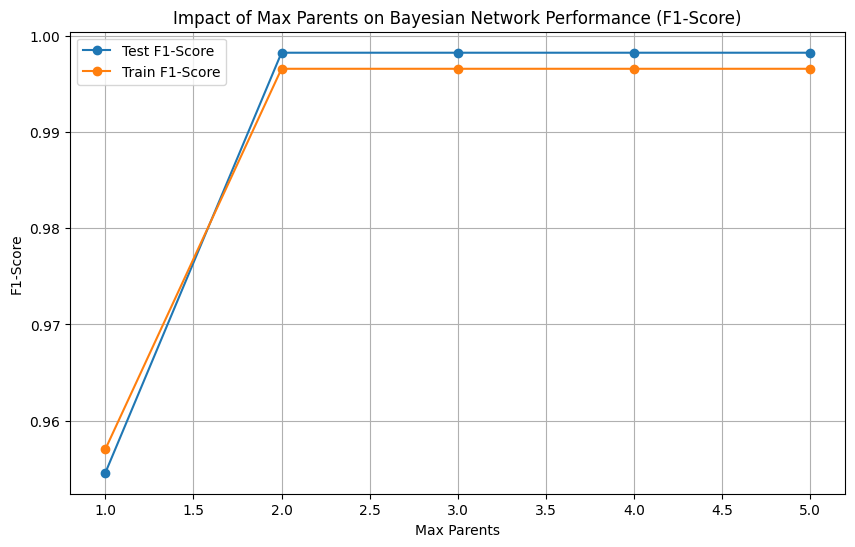

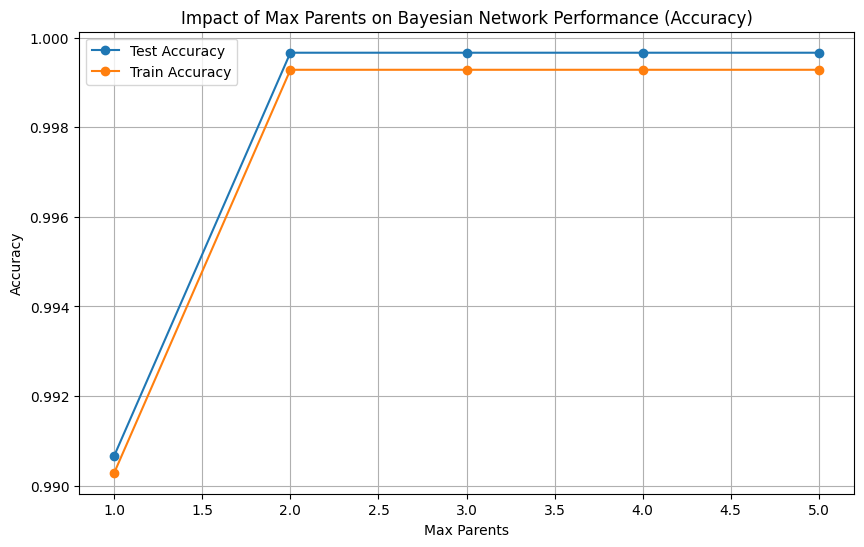

In [15]:
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianNetwork
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import networkx as nx


data = pd.read_csv("/content/ASIA10k_v2.csv")

data_encoded = data.apply(lambda x: x.astype('category').cat.codes if x.dtype == 'object' else x)

train_data, test_data = train_test_split(data_encoded, test_size=0.3, random_state=42)

def evaluate_model(model, train_data, test_data, target):

    train_pred = model.predict(train_data.drop(columns=[target]))
    test_pred = model.predict(test_data.drop(columns=[target]))

    metrics = {
        'train_accuracy': accuracy_score(train_data[target], train_pred[target]),
        'test_accuracy': accuracy_score(test_data[target], test_pred[target]),
        'train_f1': f1_score(train_data[target], train_pred[target], average='macro'),
        'test_f1': f1_score(test_data[target], test_pred[target], average='macro')
    }
    return metrics

def draw_bayesian_network(edges):
    dag = nx.DiGraph()
    dag.add_edges_from(edges)

    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(dag)
    nx.draw(dag, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
    plt.title("Bayesian Network DAG")
    plt.show()

target = 'lung'
results = []

for max_parents in [1, 2, 3, 4, 5]:
    hc = HillClimbSearch(train_data)
    best_model = hc.estimate(max_indegree=max_parents)

    bn_model = BayesianNetwork(best_model.edges())
    bn_model.fit(train_data)

    metrics = evaluate_model(bn_model, train_data, test_data, target)
    metrics['max_parents'] = max_parents
    results.append(metrics)

    print(f"Drawing DAG for max_parents={max_parents}")
    draw_bayesian_network(best_model.edges())

results_df = pd.DataFrame(results)

print(results_df)
results_df.to_csv("bayesian_network_results.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(results_df['max_parents'], results_df['test_f1'], label='Test F1-Score', marker='o')
plt.plot(results_df['max_parents'], results_df['train_f1'], label='Train F1-Score', marker='o')
plt.xlabel("Max Parents")
plt.ylabel("F1-Score")
plt.title("Impact of Max Parents on Bayesian Network Performance (F1-Score)")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_df['max_parents'], results_df['test_accuracy'], label='Test Accuracy', marker='o')
plt.plot(results_df['max_parents'], results_df['train_accuracy'], label='Train Accuracy', marker='o')
plt.xlabel("Max Parents")
plt.ylabel("Accuracy")
plt.title("Impact of Max Parents on Bayesian Network Performance (Accuracy)")
plt.legend()
plt.grid()
plt.show()
